# Setup

In [49]:
# install.packages("dplyr")
# install.packages("pROC")
# install.packages("ggplot2")

In [50]:
library(dplyr)
library(pROC)
library(ggplot2)

In [ ]:
input_dir_1 <- "../8_ROC/6-UNI/UNI_familias-cleaned-LR"                         # CHANGE THIS
output_dir_1 <- "../8_ROC/6-UNI/UNI_ROC"                                        # CHANGE THIS

# Find all cleaned LR files

In [52]:
clean_files <- list.files(
  path       = input_dir_1,
  pattern    = "^.*_cleanLR\\.txt$",                                
  full.names = TRUE
)

if (length(clean_files) == 0) {
  stop("No cleaned files found.")
}

cat("Found", length(clean_files), "cleaned LR files:\n")
print(basename(clean_files))

Found 7 cleaned LR files:
[1] "UNI_23aSTR_cleanLR.txt"         "UNI_23astr-90iisnp_cleanLR.txt"
[3] "UNI_23astr-94iisnp_cleanLR.txt" "UNI_27astr_cleanLR.txt"        
[5] "UNI_27astr-94iisnp_cleanLR.txt" "UNI_90iisnp_cleanLR.txt"       
[7] "UNI_94iisnp_cleanLR.txt"       


# Create function to compute ROC +AUC + ggplot ROC for one panel

In [53]:
compute_roc <- function(file_path, output_dir_1) {
    df <- read.table(file_path, header = TRUE)

    #Get name of marker panel and relationship
    panel_name <- strsplit(basename(file_path), "_")[[1]][2]
    rel_name <- strsplit(basename(file_path), "_")[[1]][1]
    
    #Get colums labels of dataframe
    col_true <- names(df)[1]
    col_unrel <- names(df)[2]

    # Convert to log10(LR)
    LR_true   <- log10(df[[col_true]])
    LR_unrel  <- log10(df[[col_unrel]])

    # Labels: 1 = related, 0 = unrelated
    y   <- c(rep(1, length(LR_true)), rep(0, length(LR_unrel)))
    scores <- c(LR_true, LR_unrel)

    # ROC via pROC
    roc_obj <- roc(response = y, predictor = scores)
    auc_val <- as.numeric(auc(roc_obj))

    # Build data frame for ggplot ROC curve
    roc_df <- data.frame(
    FPR       = 1 - roc_obj$specificities,
    TPR       = roc_obj$sensitivities,
    threshold = roc_obj$thresholds,
    Panel     = panel_name
    )

    # Individual ggplot ROC curve
    p_individual <- ggplot(roc_df, aes(x = FPR, y = TPR)) +
    geom_line(size = 1.1, color = "steelblue") +
    geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "grey60") +
    coord_equal() +
    labs(
      title    = paste("ROC Curve (", rel_name, "-", panel_name, ")", sep = ""),
      subtitle = paste("AUC:", format(auc_val, digits = 15, scientific = TRUE)),
      x        = "False Positive Rate (1 - Specificity)",
      y        = "True Positive Rate (Sensitivity)"
    ) +
    theme_minimal(base_size = 14)

    # Save per-panel ROC figure
    roc_png <- file.path(output_dir_1, paste0("ROC_", rel_name, "_", panel_name, ".png"))
    ggsave(roc_png, plot = p_individual, width = 7, height = 6, dpi = 300)
    print(p_individual)
    cat("Saved individual ROC plot:", roc_png, "\n")
    
    # Return:
    # - summary row for AUC table
    # - roc_df for combined plotting
    list(
        auc_row = data.frame(
        Panel = panel_name,
        AUC = format(auc_val, digits = 20, scientific = TRUE),
        N_sim = nrow(df),
        stringsAsFactors = FALSE
        ),
        roc_df = roc_df
    )
}

# Loop over all panels


Processing: UNI_23aSTR_cleanLR.txt 


Setting levels: control = 0, case = 1

Setting direction: controls < cases



Saved individual ROC plot: ../8_ROC/6-UNI/UNI_ROC/ROC_UNI_23aSTR.png 

Processing: UNI_23astr-90iisnp_cleanLR.txt 


Setting levels: control = 0, case = 1

Setting direction: controls < cases



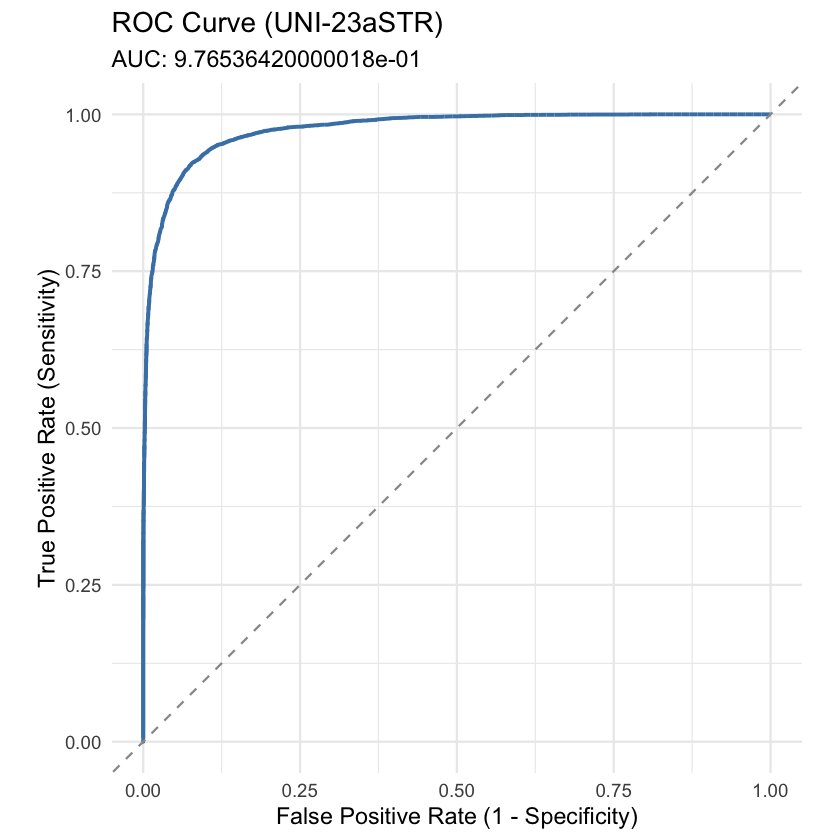

Saved individual ROC plot: ../8_ROC/6-UNI/UNI_ROC/ROC_UNI_23astr-90iisnp.png 

Processing: UNI_23astr-94iisnp_cleanLR.txt 


Setting levels: control = 0, case = 1

Setting direction: controls < cases



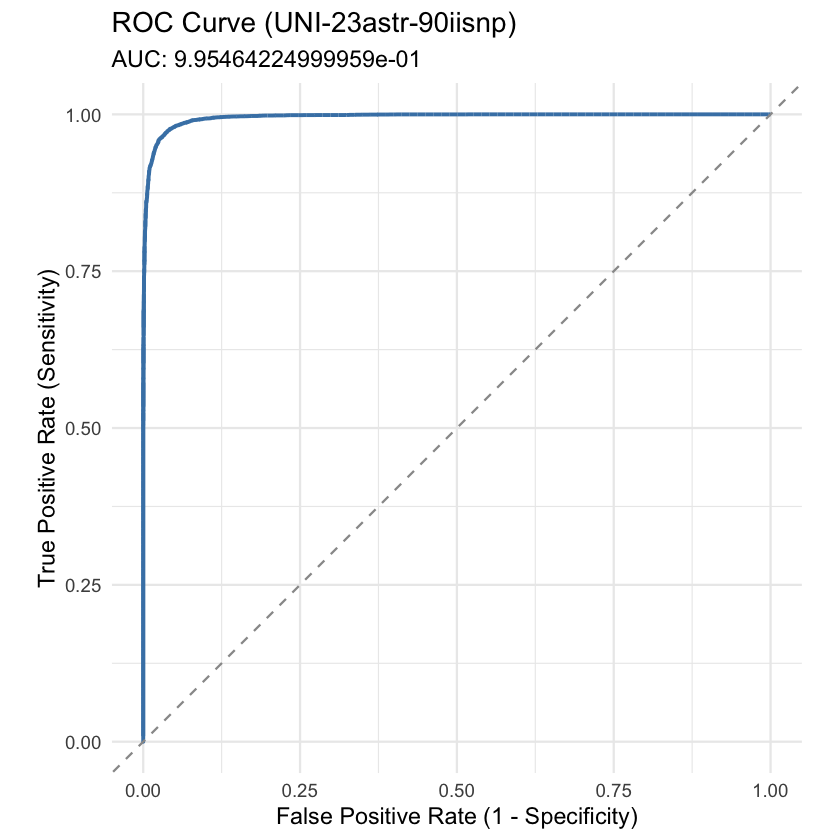

Saved individual ROC plot: ../8_ROC/6-UNI/UNI_ROC/ROC_UNI_23astr-94iisnp.png 

Processing: UNI_27astr_cleanLR.txt 


Setting levels: control = 0, case = 1

Setting direction: controls < cases



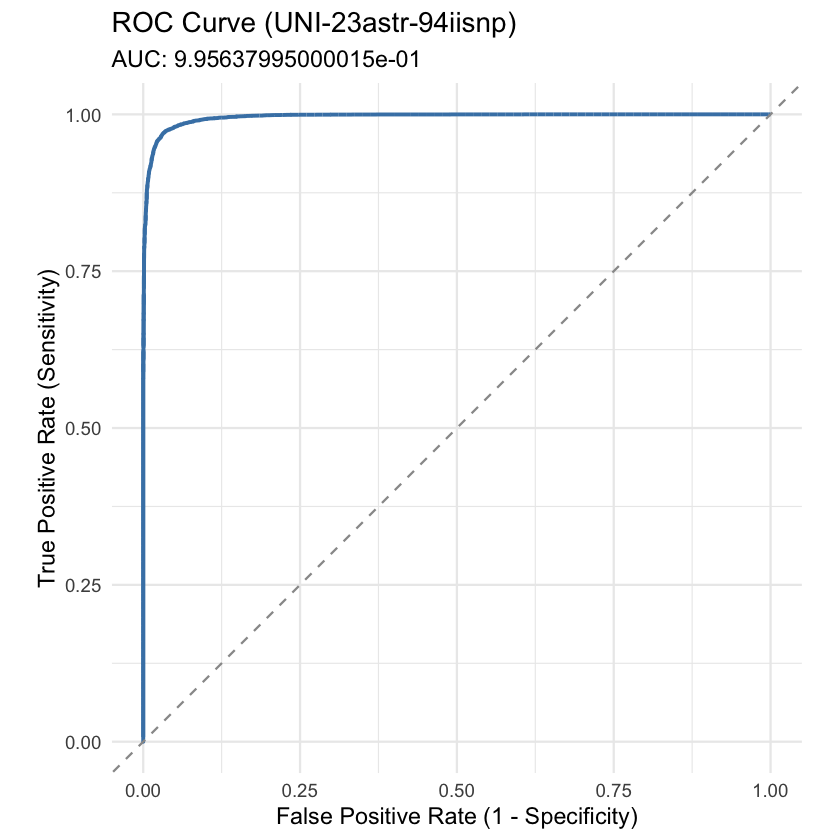

Saved individual ROC plot: ../8_ROC/6-UNI/UNI_ROC/ROC_UNI_27astr.png 

Processing: UNI_27astr-94iisnp_cleanLR.txt 


Setting levels: control = 0, case = 1

Setting direction: controls < cases



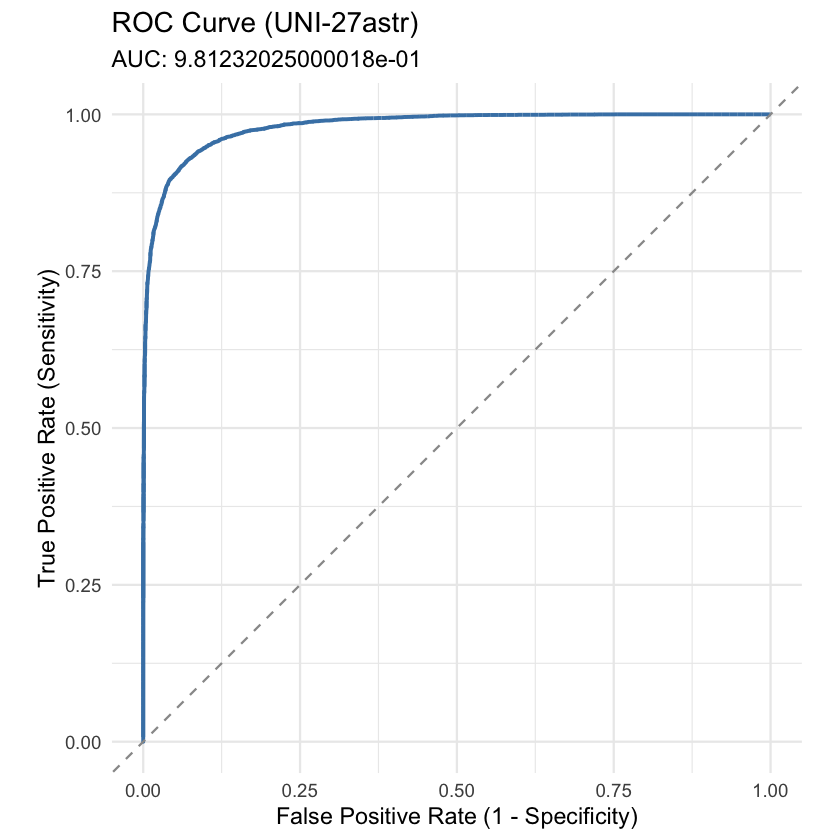

Saved individual ROC plot: ../8_ROC/6-UNI/UNI_ROC/ROC_UNI_27astr-94iisnp.png 

Processing: UNI_90iisnp_cleanLR.txt 


Setting levels: control = 0, case = 1

Setting direction: controls < cases



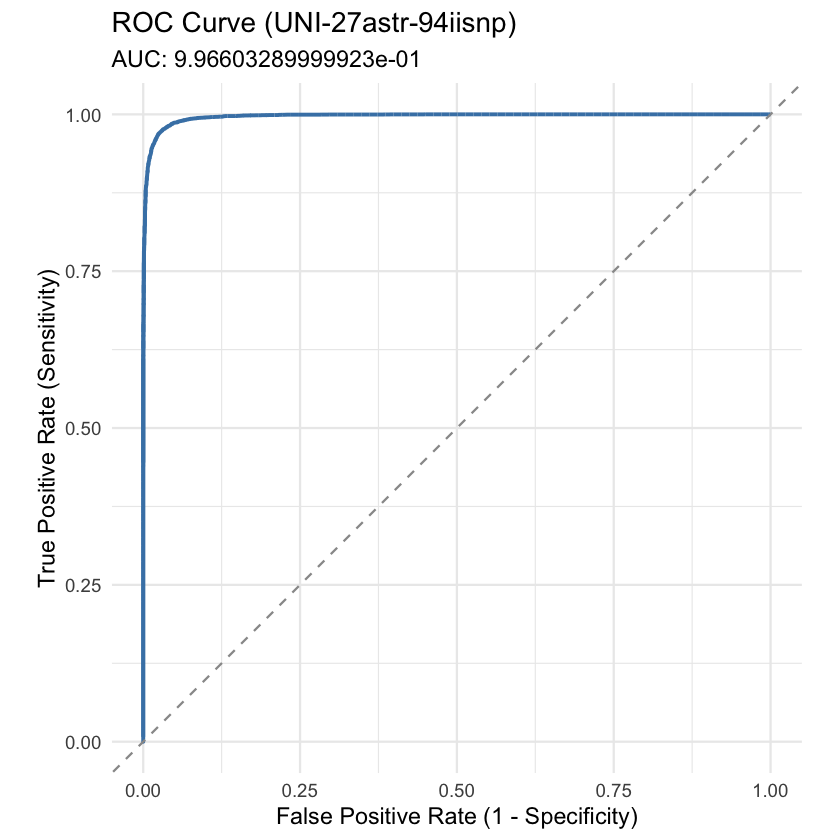

Saved individual ROC plot: ../8_ROC/6-UNI/UNI_ROC/ROC_UNI_90iisnp.png 

Processing: UNI_94iisnp_cleanLR.txt 


Setting levels: control = 0, case = 1

Setting direction: controls < cases



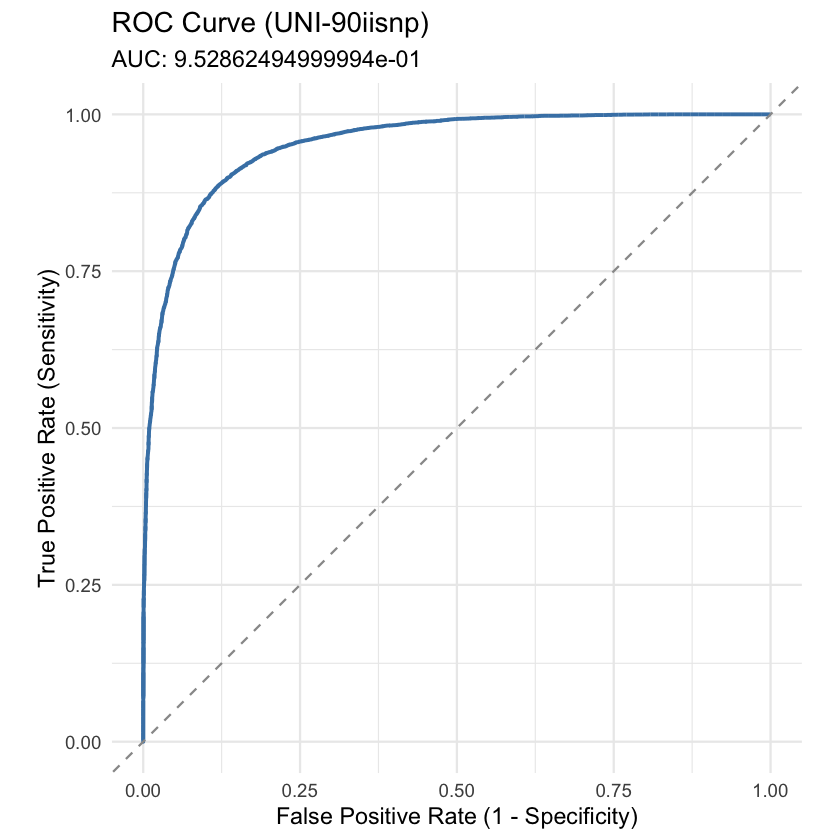

Saved individual ROC plot: ../8_ROC/6-UNI/UNI_ROC/ROC_UNI_94iisnp.png 


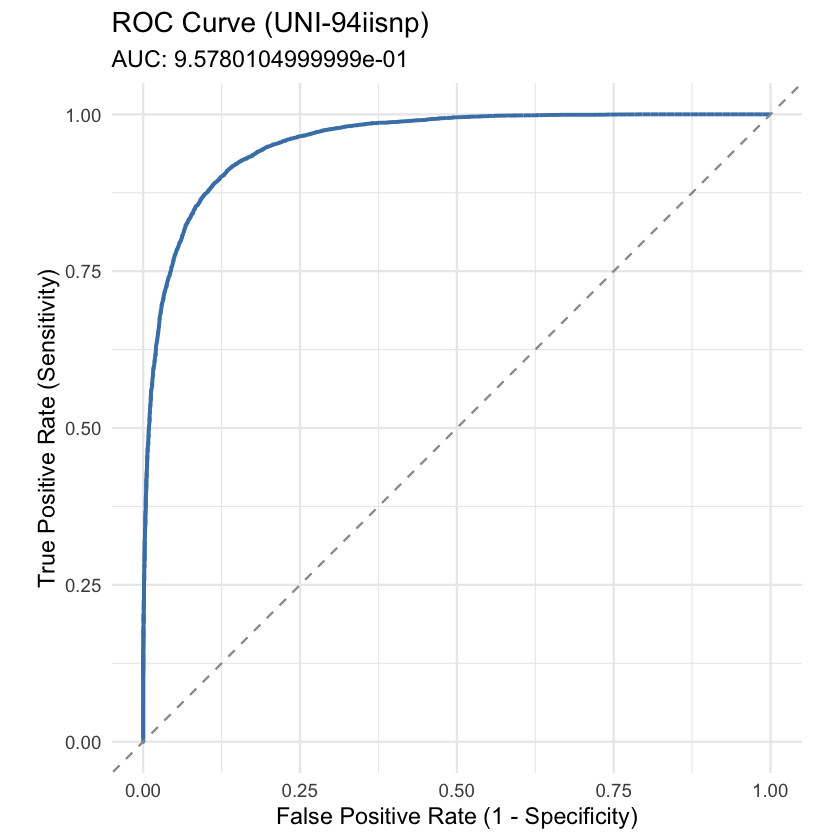

In [54]:
auc_list   <- vector("list", length(clean_files))
rocdf_list <- vector("list", length(clean_files))

for (i in seq_along(clean_files)) {
  f <- clean_files[i]
  cat("\nProcessing:", basename(f), "\n")
  res <- compute_roc(f, output_dir_1)
  auc_list[[i]]   <- res$auc_row
  rocdf_list[[i]] <- res$roc_df
}

auc_table <- bind_rows(auc_list)
roc_all   <- bind_rows(rocdf_list)

# Save AUC summary table

In [55]:
# Build ROC objects for DeLong's test for AUC comparison
roc_list <- vector("list", length(clean_files))
panel_names <- character(length(clean_files))

for (i in seq_along(clean_files)) {
  df_tmp <- read.table(clean_files[i], header = TRUE)
  
  # Derive panel name from filename (same rule as in compute_roc)
  panel_name_tmp <- strsplit(basename(clean_files[i]), "_")[[1]][2]
  
  # Column labels
  col_true_tmp  <- names(df_tmp)[1]
  col_unrel_tmp <- names(df_tmp)[2]
  
  # Convert to log10(LR)
  LR_true_tmp  <- log10(df_tmp[[col_true_tmp]])
  LR_unrel_tmp <- log10(df_tmp[[col_unrel_tmp]])
  
  # Labels: 1 = related, 0 = unrelated
  labels_tmp <- c(rep(1, length(LR_true_tmp)), rep(0, length(LR_unrel_tmp)))
  scores_tmp <- c(LR_true_tmp, LR_unrel_tmp)
  
  # ROC object for this panel
  roc_list[[i]] <- roc(response = labels_tmp,
                       predictor = scores_tmp,
                       quiet = TRUE)
  
  panel_names[i] <- panel_name_tmp
}

names(roc_list) <- panel_names

# Choose reference panel for DeLong's test (first panel in AUC table)
reference_panel <- auc_table$Panel[1]

# Add DeLong p-values as the 3rd column in AUC summary (after AUC)
auc_table <- auc_table %>%
  mutate(
    p_Delong = sapply(
      Panel,
      function(p) {
        if (p == reference_panel) {
          return(NA_real_)
        } else {
          as.numeric(
            roc.test(
              roc_list[[p]],
              roc_list[[reference_panel]],
              method = "delong",
              paired = TRUE
            )$p.value
          )
        }
      }
    )
  ) %>%
  relocate(p_Delong, .after = AUC)


# Generate name for summary table (AUC) and plots (ROC)
summaries_label <- strsplit(basename(clean_files[1]), "_")[[1]][1]

auc_outfile <- file.path(output_dir_1, paste0("AUC_summary_", summaries_label, "_panels.txt"))

write.table(
  auc_table,
  file      = auc_outfile,
  sep       = "\t",
  quote     = FALSE,
  row.names = FALSE
)

cat("\nAUC summary table saved to:", auc_outfile, "\n")
print(auc_table)


AUC summary table saved to: ../8_ROC/6-UNI/UNI_ROC/AUC_summary_UNI_panels.txt 
           Panel                       AUC      p_Delong N_sim
1         23aSTR 9.7653642000001794621e-01            NA 10000
2 23astr-90iisnp 9.9546422499995934619e-01  1.971147e-96 10000
3 23astr-94iisnp 9.9563799500001493037e-01  4.612704e-99 10000
4         27astr  9.812320250000179378e-01  3.190461e-05 10000
5 27astr-94iisnp 9.9660328999992298105e-01 7.792796e-112 10000
6        90iisnp 9.5286249499999431389e-01  8.030240e-50 10000
7        94iisnp 9.5780104999999016169e-01  2.373763e-35 10000


# Combined ROC plot (all panels together)


Combined ROC plot saved to: ../8_ROC/6-UNI/UNI_ROC/ROC_UNI_all_panels.png 


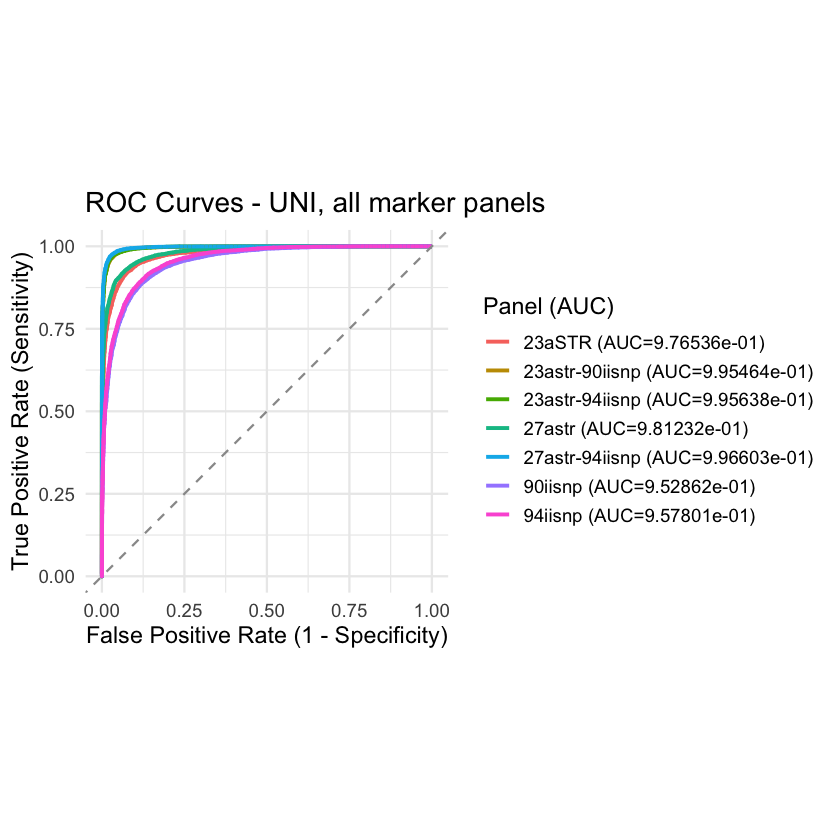

In [ ]:

# Create labels including AUC in legend
auc_labels <- auc_table %>%
  mutate(
    PanelLabel = paste0(
      Panel,
      " (AUC=",
      format(as.numeric(AUC), digits = 6, scientific = TRUE),
      ")"
    )
  )

# Map raw Panel names to PanelLabel for legend
panel_label_map <- setNames(auc_labels$PanelLabel, auc_labels$Panel)

roc_all$Panel <- factor(roc_all$Panel, levels = auc_labels$Panel)

p_combined <- ggplot(roc_all, aes(x = FPR, y = TPR, color = Panel)) +
  geom_line(size = 1.1) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "grey60") +
  coord_equal() +
  scale_color_discrete(labels = panel_label_map[levels(roc_all$Panel)]) +
  labs(
    title = paste0("ROC Curves - ", summaries_label, ", all marker panels"),
    x     = "False Positive Rate (1 - Specificity)",
    y     = "True Positive Rate (Sensitivity)",
    color = "Panel (AUC)"
  ) +
  theme_minimal(base_size = 14)

combined_png <- file.path(output_dir_1, paste0("ROC_", summaries_label, "_all_panels.png"))
ggsave(combined_png, plot = p_combined, width = 8, height = 7, dpi = 300)

print(p_combined)

cat("\nCombined ROC plot saved to:", combined_png, "\n")